# 利用GAN生成MNIST-demo

本篇代码将使用GAN来学习MNIST数据集的生成，仅仅作为一个demo演示，后面会更新更加复杂的GAN模型

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# 导入数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/')

Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/t10k-labels-idx1-ubyte.gz


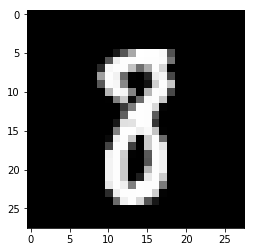

In [3]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

# 构建模型

- inputs
- generator
- descriminator
- loss && optimizer

## Inputs

In [4]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

## generator

In [5]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

## Discriminator

In [6]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

## 定义参数

In [7]:
# 定义参数
# 真实图像的size
img_size = mnist.train.images[0].shape[0]
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

In [8]:
img_size 


784

## 构建网络

In [8]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

## Loss

这里简单说一下Loss的计算方式，由于我们上面构建了两个神经网络：generator和discriminator，因此需要分别计算loss。

- discriminator
discriminator的目的在于对于给定的真图片，识别为真（1），对于generator生成的图片，识别为假（0），因此它的loss包含了真实图片的loss和生成器图片的loss两部分。

- generator
generator的目的在于让discriminator识别不出它的图片是假的，如果用1代表真，0代表假，那么generator生成的图片经过discriminator后要输出为1，因为generator想要骗过discriminator。

In [9]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

## Optimizer

由于我们在GAN里面一共训练了两个网络，所以需要分别定义优化函数。

In [10]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 训练

In [38]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.0617(Real: 0.0290 + Fake: 0.0327)... Generator Loss: 3.3821
Epoch 2/300... Discriminator Loss: 0.5338(Real: 0.2801 + Fake: 0.2536)... Generator Loss: 6.7385
Epoch 3/300... Discriminator Loss: 0.9485(Real: 0.2005 + Fake: 0.7480)... Generator Loss: 2.5283
Epoch 4/300... Discriminator Loss: 2.0552(Real: 1.0987 + Fake: 0.9565)... Generator Loss: 0.7485
Epoch 5/300... Discriminator Loss: 1.0987(Real: 0.6463 + Fake: 0.4524)... Generator Loss: 2.2855
Epoch 6/300... Discriminator Loss: 1.1321(Real: 0.6169 + Fake: 0.5152)... Generator Loss: 1.3020
Epoch 7/300... Discriminator Loss: 1.6918(Real: 1.0899 + Fake: 0.6019)... Generator Loss: 1.7268
Epoch 8/300... Discriminator Loss: 0.3877(Real: 0.2266 + Fake: 0.1610)... Generator Loss: 3.1924
Epoch 9/300... Discriminator Loss: 0.9729(Real: 0.4253 + Fake: 0.5477)... Generator Loss: 2.7379
Epoch 10/300... Discriminator Loss: 1.3400(Real: 0.7520 + Fake: 0.5881)... Generator Loss: 1.9835
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 0.8506(Real: 0.5123 + Fake: 0.3383)... Generator Loss: 1.6679
Epoch 86/300... Discriminator Loss: 0.8044(Real: 0.4205 + Fake: 0.3840)... Generator Loss: 1.6309
Epoch 87/300... Discriminator Loss: 1.0138(Real: 0.5272 + Fake: 0.4866)... Generator Loss: 1.2681
Epoch 88/300... Discriminator Loss: 0.7303(Real: 0.3577 + Fake: 0.3727)... Generator Loss: 1.4353
Epoch 89/300... Discriminator Loss: 0.9498(Real: 0.5454 + Fake: 0.4044)... Generator Loss: 1.3467
Epoch 90/300... Discriminator Loss: 0.8841(Real: 0.4603 + Fake: 0.4239)... Generator Loss: 1.3985
Epoch 91/300... Discriminator Loss: 1.0556(Real: 0.7247 + Fake: 0.3309)... Generator Loss: 1.9762
Epoch 92/300... Discriminator Loss: 0.8849(Real: 0.3565 + Fake: 0.5284)... Generator Loss: 1.2069
Epoch 93/300... Discriminator Loss: 0.8133(Real: 0.3828 + Fake: 0.4305)... Generator Loss: 1.4496
Epoch 94/300... Discriminator Loss: 0.8608(Real: 0.5020 + Fake: 0.3588)... Generator Loss: 1.6487
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 1.0177(Real: 0.5426 + Fake: 0.4751)... Generator Loss: 1.3077
Epoch 169/300... Discriminator Loss: 0.9669(Real: 0.4684 + Fake: 0.4986)... Generator Loss: 1.3155
Epoch 170/300... Discriminator Loss: 1.0222(Real: 0.4604 + Fake: 0.5618)... Generator Loss: 1.2903
Epoch 171/300... Discriminator Loss: 1.3106(Real: 0.6530 + Fake: 0.6576)... Generator Loss: 1.2164
Epoch 172/300... Discriminator Loss: 1.2289(Real: 0.4982 + Fake: 0.7307)... Generator Loss: 1.1728
Epoch 173/300... Discriminator Loss: 1.1053(Real: 0.5146 + Fake: 0.5907)... Generator Loss: 1.2347
Epoch 174/300... Discriminator Loss: 0.9682(Real: 0.4249 + Fake: 0.5433)... Generator Loss: 1.2140
Epoch 175/300... Discriminator Loss: 1.1272(Real: 0.4912 + Fake: 0.6360)... Generator Loss: 1.0328
Epoch 176/300... Discriminator Loss: 0.9626(Real: 0.5331 + Fake: 0.4295)... Generator Loss: 1.4480
Epoch 177/300... Discriminator Loss: 0.9253(Real: 0.5445 + Fake: 0.3808)... Generator Loss: 1.4691
Epoch 178/

Epoch 251/300... Discriminator Loss: 1.0160(Real: 0.5956 + Fake: 0.4205)... Generator Loss: 1.4440
Epoch 252/300... Discriminator Loss: 0.8260(Real: 0.3923 + Fake: 0.4337)... Generator Loss: 1.6022
Epoch 253/300... Discriminator Loss: 0.9616(Real: 0.5955 + Fake: 0.3660)... Generator Loss: 1.7815
Epoch 254/300... Discriminator Loss: 0.9371(Real: 0.4354 + Fake: 0.5017)... Generator Loss: 1.3889
Epoch 255/300... Discriminator Loss: 0.9953(Real: 0.4124 + Fake: 0.5829)... Generator Loss: 1.3377
Epoch 256/300... Discriminator Loss: 0.9748(Real: 0.5850 + Fake: 0.3898)... Generator Loss: 1.6799
Epoch 257/300... Discriminator Loss: 1.0371(Real: 0.5326 + Fake: 0.5045)... Generator Loss: 1.3548
Epoch 258/300... Discriminator Loss: 0.8225(Real: 0.4653 + Fake: 0.3572)... Generator Loss: 1.4773
Epoch 259/300... Discriminator Loss: 1.2285(Real: 0.6123 + Fake: 0.6162)... Generator Loss: 1.2264
Epoch 260/300... Discriminator Loss: 0.8770(Real: 0.4695 + Fake: 0.4075)... Generator Loss: 1.6845
Epoch 261/

# 绘制loss曲线

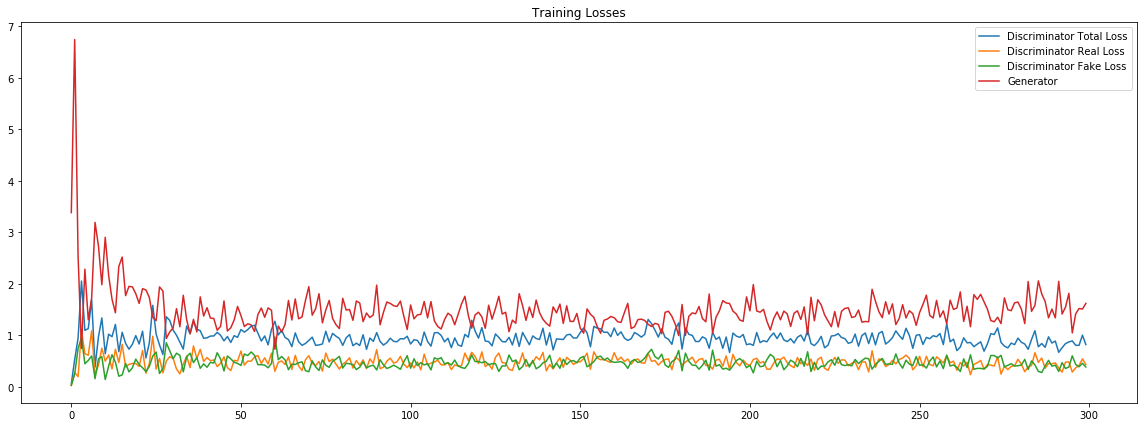

In [39]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

# 显示图像

In [40]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [41]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

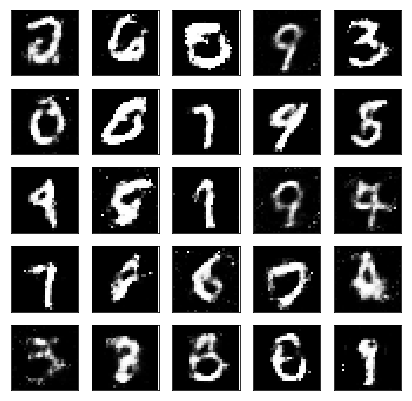

In [42]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

# 显示整个生成过程图片

In [43]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300轮，不要越界
#epoch_idx = [0, 5, 10 ,20, 40, 60, 80] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

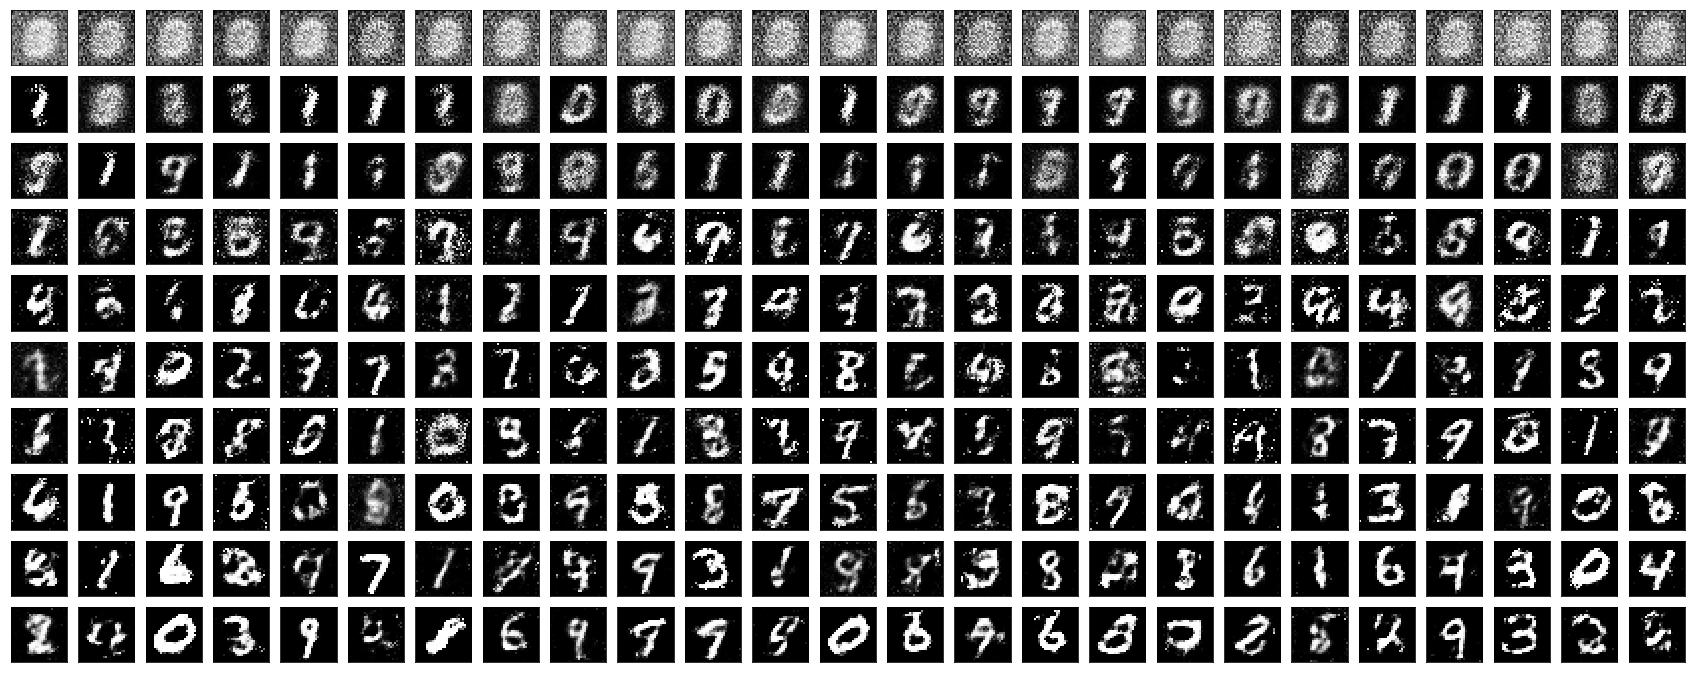

In [44]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# 生成新的图片

In [45]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})


INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


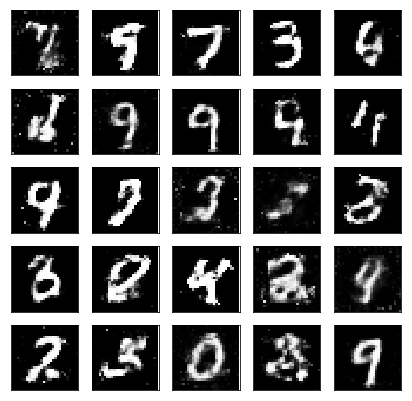

In [46]:
_ = view_samples(0, [gen_samples])